## Gen data

In [ ]:
import os
import numpy as np

def load_img(img_dir, img_list):
  images=[]
  for i, image_name in enumerate(img_list):
    if (image_name.split('.')[1] == 'npy'):
      image = np.load(img_dir+image_name)

      images.append(image)
  images = np.array(images)
  return(images)

def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

  L = len(img_list)

  while True:

    batch_start = 0
    batch_end = batch_size

    while batch_start < L:
      limit = min(batch_end, L)

      X = load_img(img_dir, img_list[batch_start:limit])
      Y = load_img(mask_dir, mask_list[batch_start:limit])

      yield (X, Y)

      batch_start += batch_size
      batch_end += batch_size

In [ ]:
from matplotlib import pyplot as plt
import random

train_img_dir = "/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data/DS312_output_project/train/img/"
train_mask_dir = "/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data/DS312_output_project/train/mask/"
train_img_list = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

In [ ]:
print('Num trains: ',len(train_img_list),'\nNum mask: ', len(train_mask_list))

Num trains:  258 
Num mask:  258


In [ ]:
batch_size = 2
train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

In [ ]:
train_img_datagen

<generator object imageLoader at 0x7ff37b789e00>

In [ ]:
img, msk = train_img_datagen.__next__()

In [ ]:
print("Img shape trains: ", img.shape, "\nMask shape trains: ", msk.shape)

'''
Img shape trains:  (2, 128, 128, 128, 3)
 2: batch size(số lượng hình ảnh load lên),
 128, 128, 128: lần lượt là kích thước ảnh,
 3: 3 ảnh ghép lại
 _________________________________________
 Mask shape trains:  (2, 128, 128, 128, 4)
 Tương tự:
  4: 4 nhãn
'''

Img shape trains:  (2, 128, 128, 128, 3) 
Mask shape trains:  (2, 128, 128, 128, 4)


'\nImg shape trains:  (2, 128, 128, 128, 3) \n 2: batch size(số lượng hình ảnh load lên), \n 128, 128, 128: lần lượt là kích thước ảnh,\n 3: 3 ảnh ghép lại\n _________________________________________\n Mask shape trains:  (2, 128, 128, 128, 4)\n Tương tự:\n  4: 4 nhãn\n'

Img mun: 1 
n_slice:  76


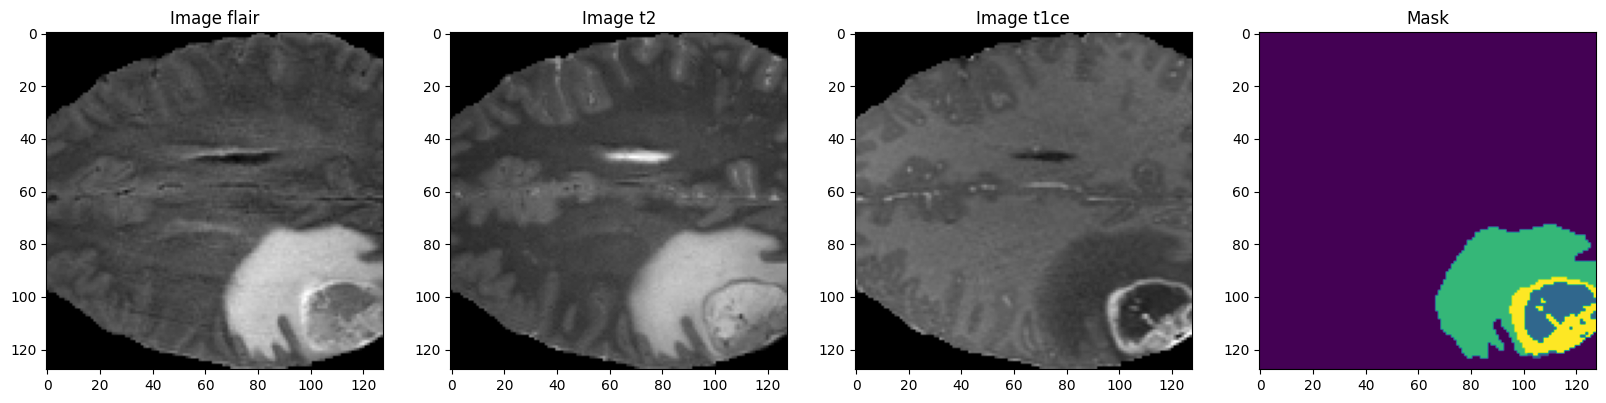

In [ ]:
img_num = random.randint(0,img.shape[0]-1)
test_img = img[img_num]
test_mask = msk[img_num]
test_mask = np.argmax(test_mask, axis=3)

n_slice = random.randint(0, test_mask.shape[2])
print("Img mun:", img_num , "\nn_slice: ", n_slice)

fig, axes = plt.subplots(1, 4, figsize=(20, 7))
axes[0].imshow(test_img[:,:,n_slice, 0], cmap='gray')
axes[0].set_title('Image flair')
axes[1].imshow(test_img[:,:,n_slice, 2], cmap='gray')
axes[1].set_title('Image t2')
axes[2].imshow(test_img[:,:,n_slice, 1], cmap='gray')
axes[2].set_title('Image t1ce')
axes[3].imshow(test_mask[:, :, n_slice])
axes[3].set_title('Mask')
plt.show()

## Build model 3D

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform'

################################################################

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))

    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible.
    model.summary()

    return model

#Test if everything is working ok.
model = simple_unet_model(128, 128, 128, 3, 4)

In [ ]:
print(model.input_shape)
print(model.output_shape)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


## Train

In [ ]:
import keras
from matplotlib import pyplot as plt
import glob

In [ ]:
train_img_dir = "/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data/DS312_output_project/train/img/"
train_mask_dir = "/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data/DS312_output_project/train/mask/"

val_img_dir = "/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data/DS312_output_project/val/img/"
val_mask_dir = "/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data/DS312_output_project/val/mask/"

train_img_list = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list = os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

batch_size = 2

In [ ]:
print("train_img_list: ", len(train_img_list))
print("train_mask_list: ", len(train_mask_list))
print("val_img_list: ", len(val_img_list))
print("val_mask_list: ", len(val_mask_list))

train_img_list:  258
train_mask_list:  258
val_img_list:  86
val_mask_list:  86


In [ ]:
train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

img, msk = train_img_datagen.__next__()

### Define loss, metrics and optimizer to be used for training

In [ ]:
pip install segmentation_models_3D

In [ ]:
wt0, wt1, wt2, wt3 = 0.25, 0.25, 0.25, 0.25 # gán trọng số cho các nhãn bằng nhau
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights = np.array([wt0, wt1, wt2, wt3]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001 # learning rate
optim = keras.optimizers.Adam(LR) # optimizers

Segmentation Models: using `tf.keras` framework.


### Fit the model

In [ ]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

In [ ]:
model = simple_unet_model(IMG_HEIGHT = 128,
                          IMG_WIDTH = 128,
                          IMG_DEPTH = 128,
                          IMG_CHANNELS = 3,
                          num_classes = 4)

In [ ]:
model.compile(optimizer = optim, loss=total_loss, metrics = metrics)
print(model.summary())

In [ ]:
print(model.input_shape)
print(model.output_shape)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [ ]:
history = model.fit(train_img_datagen,
          steps_per_epoch = steps_per_epoch,
          epochs = 100,
          verbose = 1,
          validation_data = val_img_datagen,
          validation_steps = val_steps_per_epoch,
          )


In [ ]:
model.save('/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data/DS312_output_project/model.hdf5')

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Load model

In [ ]:
from keras.models import load_model
from keras.metrics import MeanIoU

In [ ]:
my_model = load_model('/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data/DS312_output_project/model.hdf5',
                      compile=False)

In [ ]:

batch_size = 8

test_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

## Test

1/1 [==============================] - 0s 73ms/step
(1, 128, 128, 128, 4)


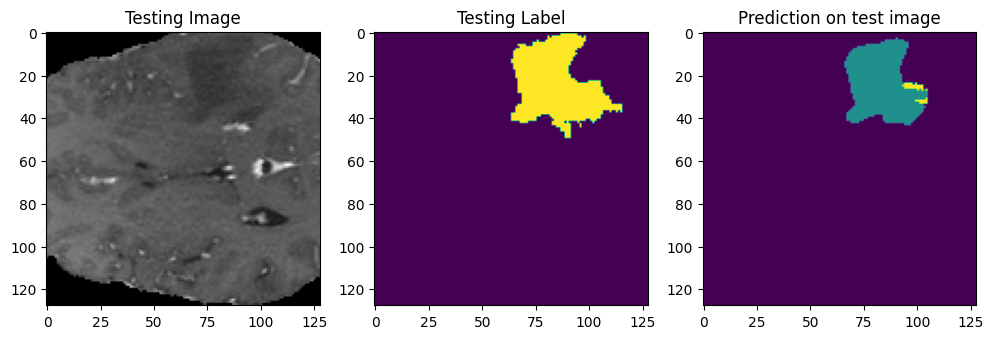

In [ ]:
img_num = 15

test_img = np.load("/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data/DS312_output_project/val/img/image_"+str(img_num)+".npy")

test_mask = np.load("/content/drive/MyDrive/HK2-2023/Xử lý ảnh y khoa/Project/Data/DS312_output_project/val/mask/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
print(test_prediction.shape)
test_prediction_argmax = np.argmax(test_prediction, axis=4)[0,:,:,:]

from matplotlib import pyplot as plt
import random

n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()


In [ ]:
a = test_prediction_argmax[:,:, n_slice]
label = test_mask_argmax[:,:,n_slice]
# 1: Xanh, 2 Vàng

In [ ]:
for row in a:
    print(row)

In [ ]:
for row in label:
    print(row)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 